---
title: "Missing data imputation for UK Biobank"
author: "Saikat Banerjee"
format:
  html: default
date: "2024-02-28"
file-modified: "2024-02-28"
abstract: "We hold out (mask) some of the data points, and then apply the methods to obtain estimates of the missing values."

---

In [1]:
import os
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')

from scipy.cluster import hierarchy as sp_hierarchy
from scipy.spatial import procrustes as sp_procrustes

import sys
sys.path.append("../utils/")
import plot_functions as mpy_plotfn

In [2]:
def get_masked_rmse(original, recovered, mask = None):
    if mask is None: mask = np.ones_like(original)
    mse = np.sum(np.square((original - recovered) * mask)) / np.sum(mask)
    return np.sqrt(mse)

In [3]:
data_dir = "/gpfs/commons/home/sbanerjee/work/npd/PanUKB/data"
h2_cut = 0.1
pval_cut = 5e-8

zscore_df = pd.read_pickle(os.path.join(data_dir, f"modselect/zscore_h2{h2_cut}_pval{pval_cut}.pkl"))
trait_df  = pd.read_pickle(os.path.join(data_dir, f"modselect/traits_h2{h2_cut}.pkl"))

# Read masked data

In [4]:
dscout_dir = "/gpfs/commons/groups/knowles_lab/sbanerjee/low_rank_matrix_approximation_numerical_experiments/panukb"

data_filename = os.path.join(dscout_dir, f"ukbb/ukbb_1.pkl")
    
with (open(data_filename, "rb")) as fh:
    data = pickle.load(fh)

In [5]:
X = np.array(zscore_df.values.T)
#X_cent = X - np.mean(X, axis = 0, keepdims = True)
X_cent = data['Ztrue']
Z_cent = data['Z']
Z_mask = data['Zmask']

print (f"We have {X_cent.shape[0]} samples (phenotypes) and {X_cent.shape[1]} features (variants)")
print (f"Fraction of Nan entries: {np.sum(np.isnan(X)) / np.prod(X_cent.shape):.3f}")
print (f"Fraction of masked entries: {np.sum(Z_mask) / np.prod(X_cent.shape):.3f}")

zero_rmse = get_masked_rmse(X_cent, np.zeros_like(X_cent), mask = Z_mask)
print (f"RMSE of zero prediction: {zero_rmse}")

We have 216 samples (phenotypes) and 48212 features (variants)
Fraction of Nan entries: 0.000
Fraction of masked entries: 0.200
RMSE of zero prediction: 1.9950481725240365


In @fig-panukb-zscore-covariance we plot a heatmap from the covariance matrix of the Z-scores.

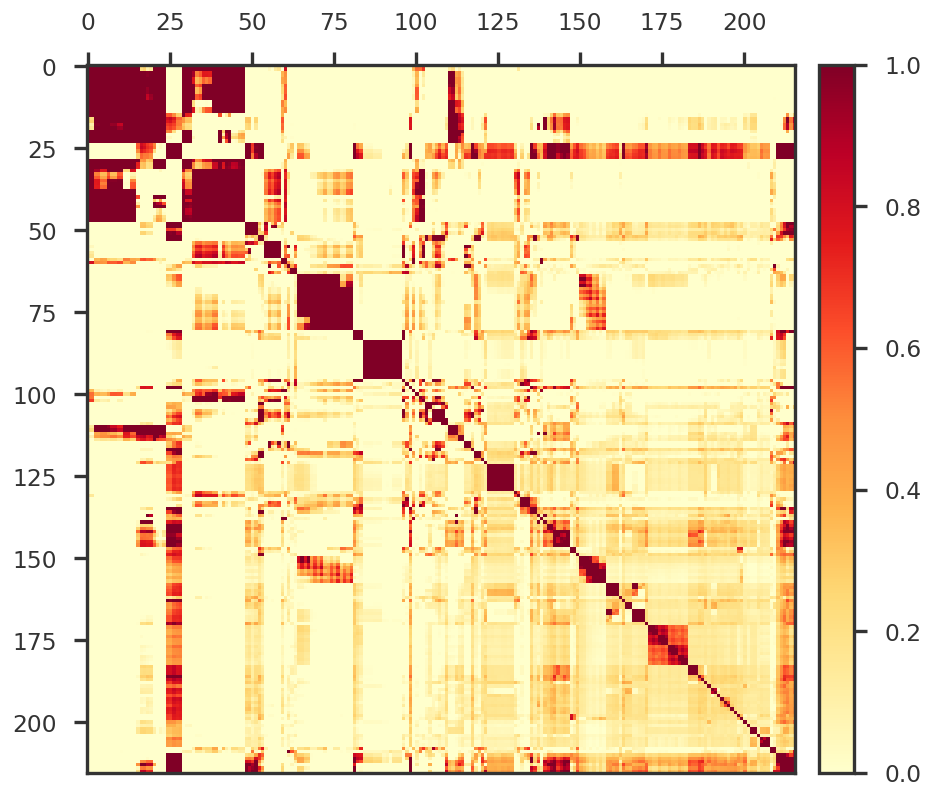

In [6]:
#| label: fig-panukb-zscore-covariance
#| fig-cap: "Covariance of Z-scores in PanUKB data"

o1 = sp_hierarchy.leaves_list(sp_hierarchy.linkage(np.cov(X_cent), method = 'centroid'))

fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)

mpy_plotfn.plot_covariance_heatmap(ax1, X_cent[o1, :])

plt.tight_layout()
plt.show()

In [7]:
method_labels = {
    "rpca" : "RPCA-IALM",
    "nnm" : "NN-FW",
    "nnm_sparse" : "NN-Sparse-FW",
    "truncated_svd": "tSVD",
    "factorgo": "FactorGO",
}

method_colors = {
    "rpca" : '#FF6800', # Vivid Orange
    "nnm" : '#C10020', # Vivid Red
    "nnm_sparse" : '#803E75', # Strong Purple
    "truncated_svd" : '#535154', # gray
    "factorgo" : '#A6BDD7', # Very Light Blue
}

optimum_rmse = dict()

# Read RPCA results

In [8]:
rpca_filename = os.path.join(dscout_dir, f"rpca/ukbb_1_rpca_1.pkl")
    
with (open(rpca_filename, "rb")) as fh:
    rpca_res = pickle.load(fh)
    
optimum_rmse['rpca'] = get_masked_rmse(X_cent, rpca_res['X'], mask = Z_mask)

To find the best possible lambda, we apply Robust PCA on the masked data with different values of $\lambda$. The RMSE of the recovered values
is shown in @fig-rpca-cv-lambda. As currently implemented, Robust PCA fails to recover the masked data and the RMSE is comparable to that from zero entries.

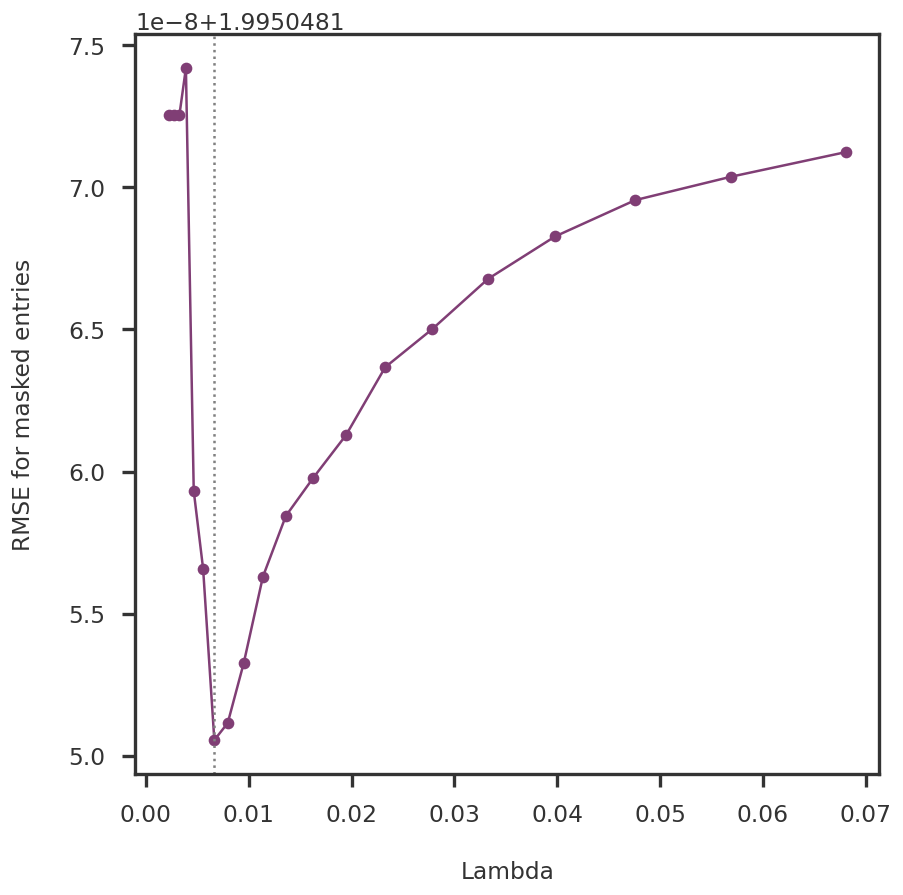

In [9]:
#| label: fig-rpca-cv-lambda
#| fig-cap: "RMSE of recovered values of masked entries in the PanUKB data"

fig = plt.figure()
ax1 = fig.add_subplot(111)

_optlmb = rpca_res['cvlmb'][np.argmin(rpca_res['cvrmse'])]

ax1.plot(rpca_res['cvlmb'], rpca_res['cvrmse'], marker = 'o')
ax1.axvline(x = _optlmb, ls = 'dotted', color = 'grey')
ax1.set_xlabel("Lambda")
ax1.set_ylabel("RMSE for masked entries")
plt.show()

# Read NNM results

In [10]:
nnm_filename = os.path.join(dscout_dir, f"nnm/ukbb_1_nnm_1.pkl")
    
with (open(nnm_filename, "rb")) as fh:
    nnm_res = pickle.load(fh)

For NNM, we consider the input as an incomplete data matrix. We perform a 2-fold cross-validation on the incomplete input data and show the RMSE for the CV and the RMSE for the cross-validation is shown in @fig-nnm-cv-rank.

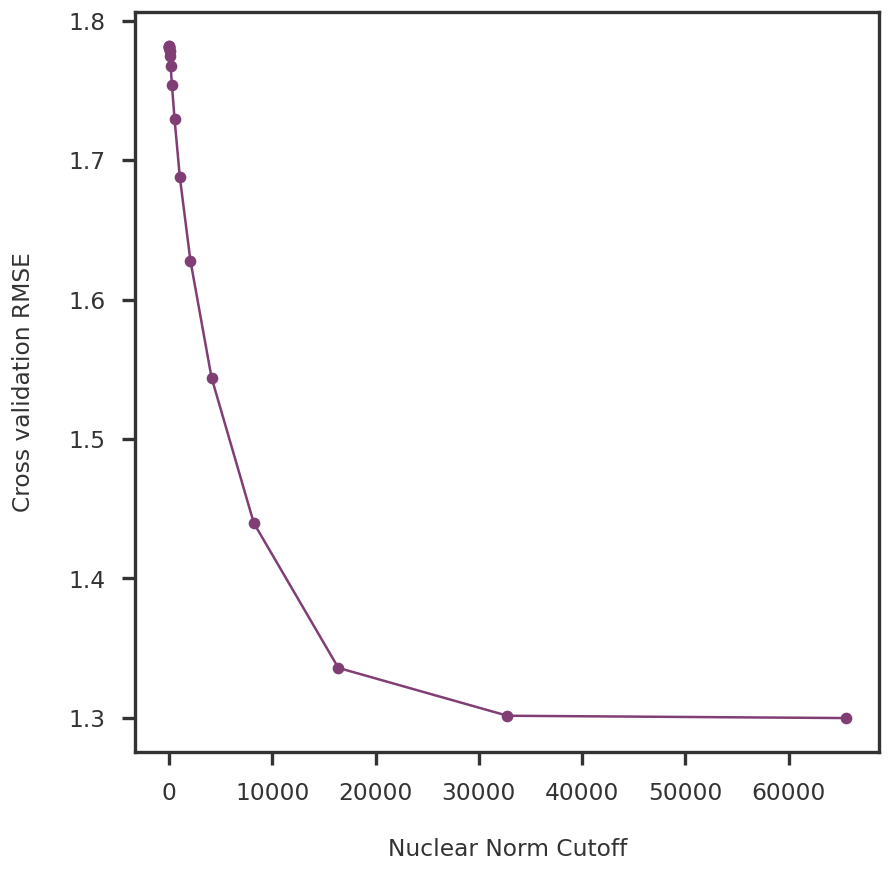

In [11]:
#| label: fig-nnm-cv-rank
#| fig-cap: "RMSE for recovery of hold-out test data"

fig = plt.figure()
ax1 = fig.add_subplot(111)

nnm_cvres = nnm_res['model']['test_error']

ax1.plot(nnm_cvres.keys(), [np.mean(x) for x in nnm_cvres.values()], marker = 'o')
ax1.set_xlabel("Nuclear Norm Cutoff")
ax1.set_ylabel("Cross validation RMSE")
plt.show()

# Read NNM Sparse results

In [12]:
rank_seq = [128.0, 256.0, 512.0, 1024.0, 2048.0, 4096.0, 8192.0, 16384.0, 32768.0, 65536.0]
nnm_sparse_res = dict()
for r in rank_seq:
    out_filename = os.path.join(dscout_dir, f"nnm_sparse/ukbb_1_nnm_sparse_{r}.pkl")
    if os.path.isfile(out_filename):
        with open(out_filename, 'rb') as fh:
            nnm_sparse_res[r] = pickle.load(fh)

In [13]:
nnm_sparse_cvres = dict()
nnm_sparse_nucnorm = dict()
for rank, model in nnm_sparse_res.items():
    nnm_sparse_cvres[rank] = get_masked_rmse(X_cent, model['X_'], mask = Z_mask)
    nnm_sparse_nucnorm[rank] = np.linalg.norm(model['X_'], 'nuc')

For the NNM Sparse model, we looked at the RMSE of the masked data predicted by NNM in the left panel of @fig-nnm-sparse-cv-rank. In the right panel, we show the nuclear norm of the recovered matrix against the input constraint.

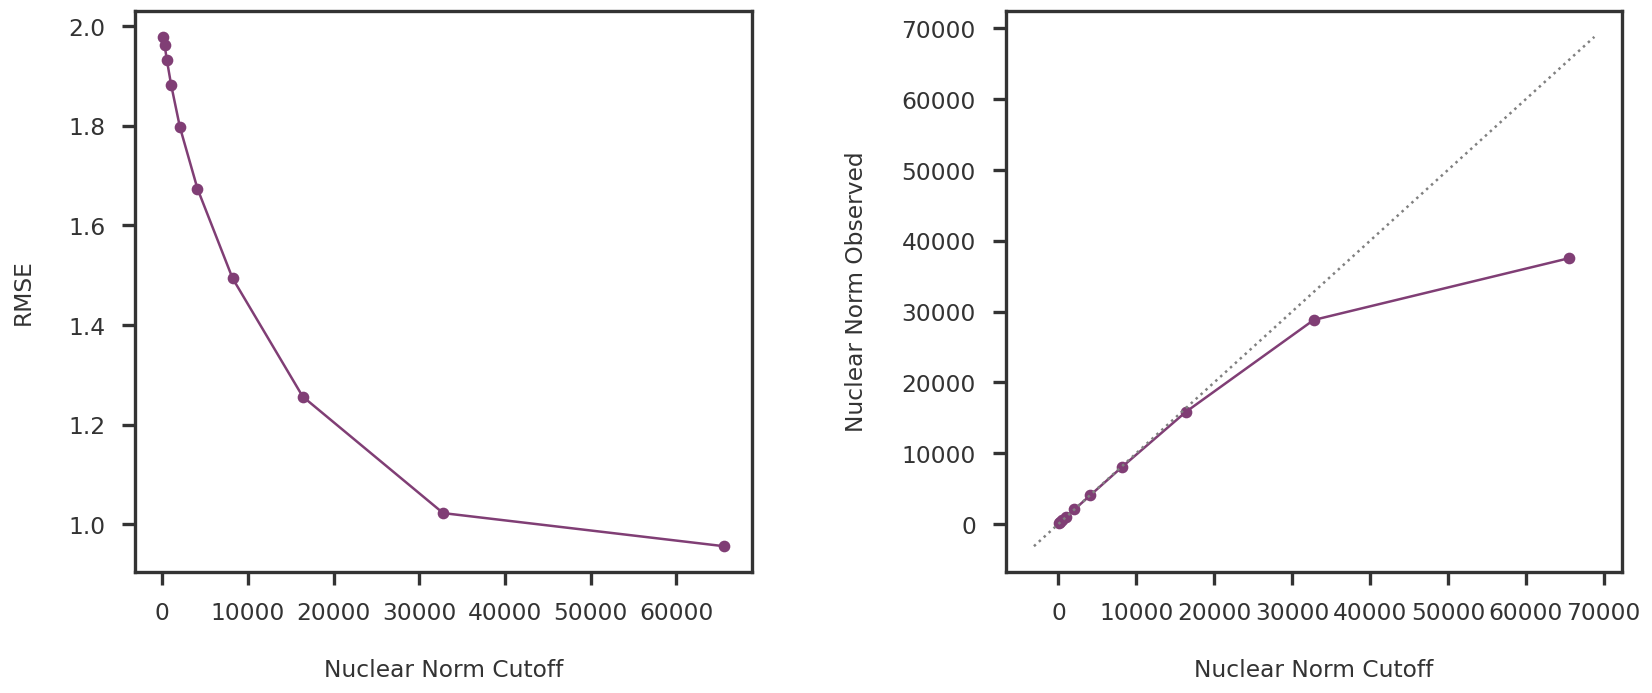

In [14]:
#| label: fig-nnm-sparse-cv-rank
#| fig-cap: "RMSE for masked data in the UK Biobank decreases with increasing rank."

fig = plt.figure(figsize = (14,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(nnm_sparse_cvres.keys(), nnm_sparse_cvres.values(), marker = 'o')
# ax1.plot(nnm_sparse_nucnorm.values(), nnm_sparse_cvres.values(), marker = 'o')
# ax1.plot(nnm_cvres.keys(), [np.mean(x) * 1.11 for x in nnm_cvres.values()], marker = 'o')
ax1.set_xlabel("Nuclear Norm Cutoff")
ax1.set_ylabel("RMSE")

ax2.plot(nnm_sparse_nucnorm.keys(), nnm_sparse_nucnorm.values(), marker = 'o')
ax2.set_xlabel("Nuclear Norm Cutoff")
ax2.set_ylabel("Nuclear Norm Observed")
mpl_utils.plot_diag(ax2)

plt.tight_layout(w_pad = 4.0)
plt.show()

In [15]:
nnm_sparse_filename = os.path.join(dscout_dir, f"nnm_sparse/ukbb_1_nnm_sparse_1.pkl")
    
with (open(nnm_sparse_filename, "rb")) as fh:
    nnm_sparse_res = pickle.load(fh)

In [16]:
optimum_rmse['nnm'] = get_masked_rmse(X_cent, nnm_res['X'], mask = Z_mask)
optimum_rmse['nnm_sparse'] = get_masked_rmse(X_cent, nnm_sparse_res['X'], mask = Z_mask)

# Truncated SVD

In [17]:
def truncated_svd(X, k):
    #X_cent = X - np.mean(X, axis = 0, keepdims = True)
    #X_cent /= np.sqrt(np.prod(X_cent.shape))
    #U, S, Vt = np.linalg.svd(X_cent, full_matrices = False)
    U, S, Vt = np.linalg.svd(X, full_matrices = False)
    U = U[:, 0:k]
    S = S[0:k]
    V = Vt.T
    V = V[:, 0:k]
    L = U @ np.diag(S)
    F = V @ np.diag(S)
    S2 = np.square(S)
    #return L, F, S2
    return L @ F.T

tsvd_X = truncated_svd(Z_cent, 100)

# X_cent_pr, tsvd_X_pr, _ = sp_procrustes(X_cent, tsvd_X)

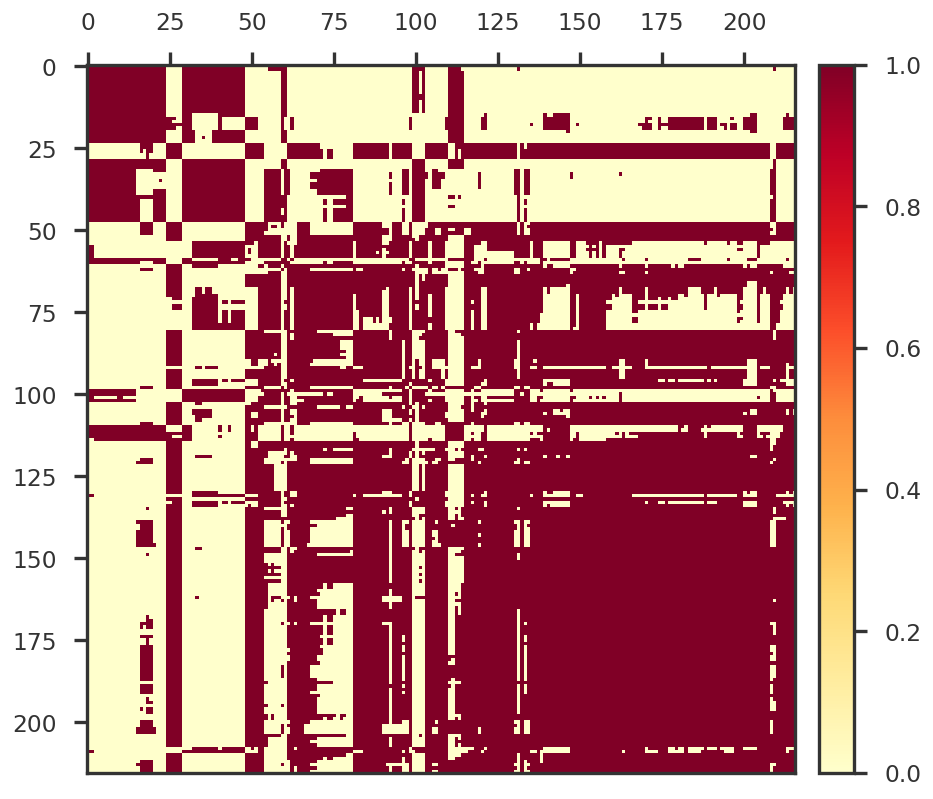

In [60]:
#| label: fig-tsvd-correlation-recovery
#| fig-cap: "Covariance of Z-scores recovered using truncated SVD"

fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)

mpy_plotfn.plot_covariance_heatmap(ax1, tsvd_X[o1, :])

plt.tight_layout()
plt.show()

# Visualize the correlation matrix with only the masked entries

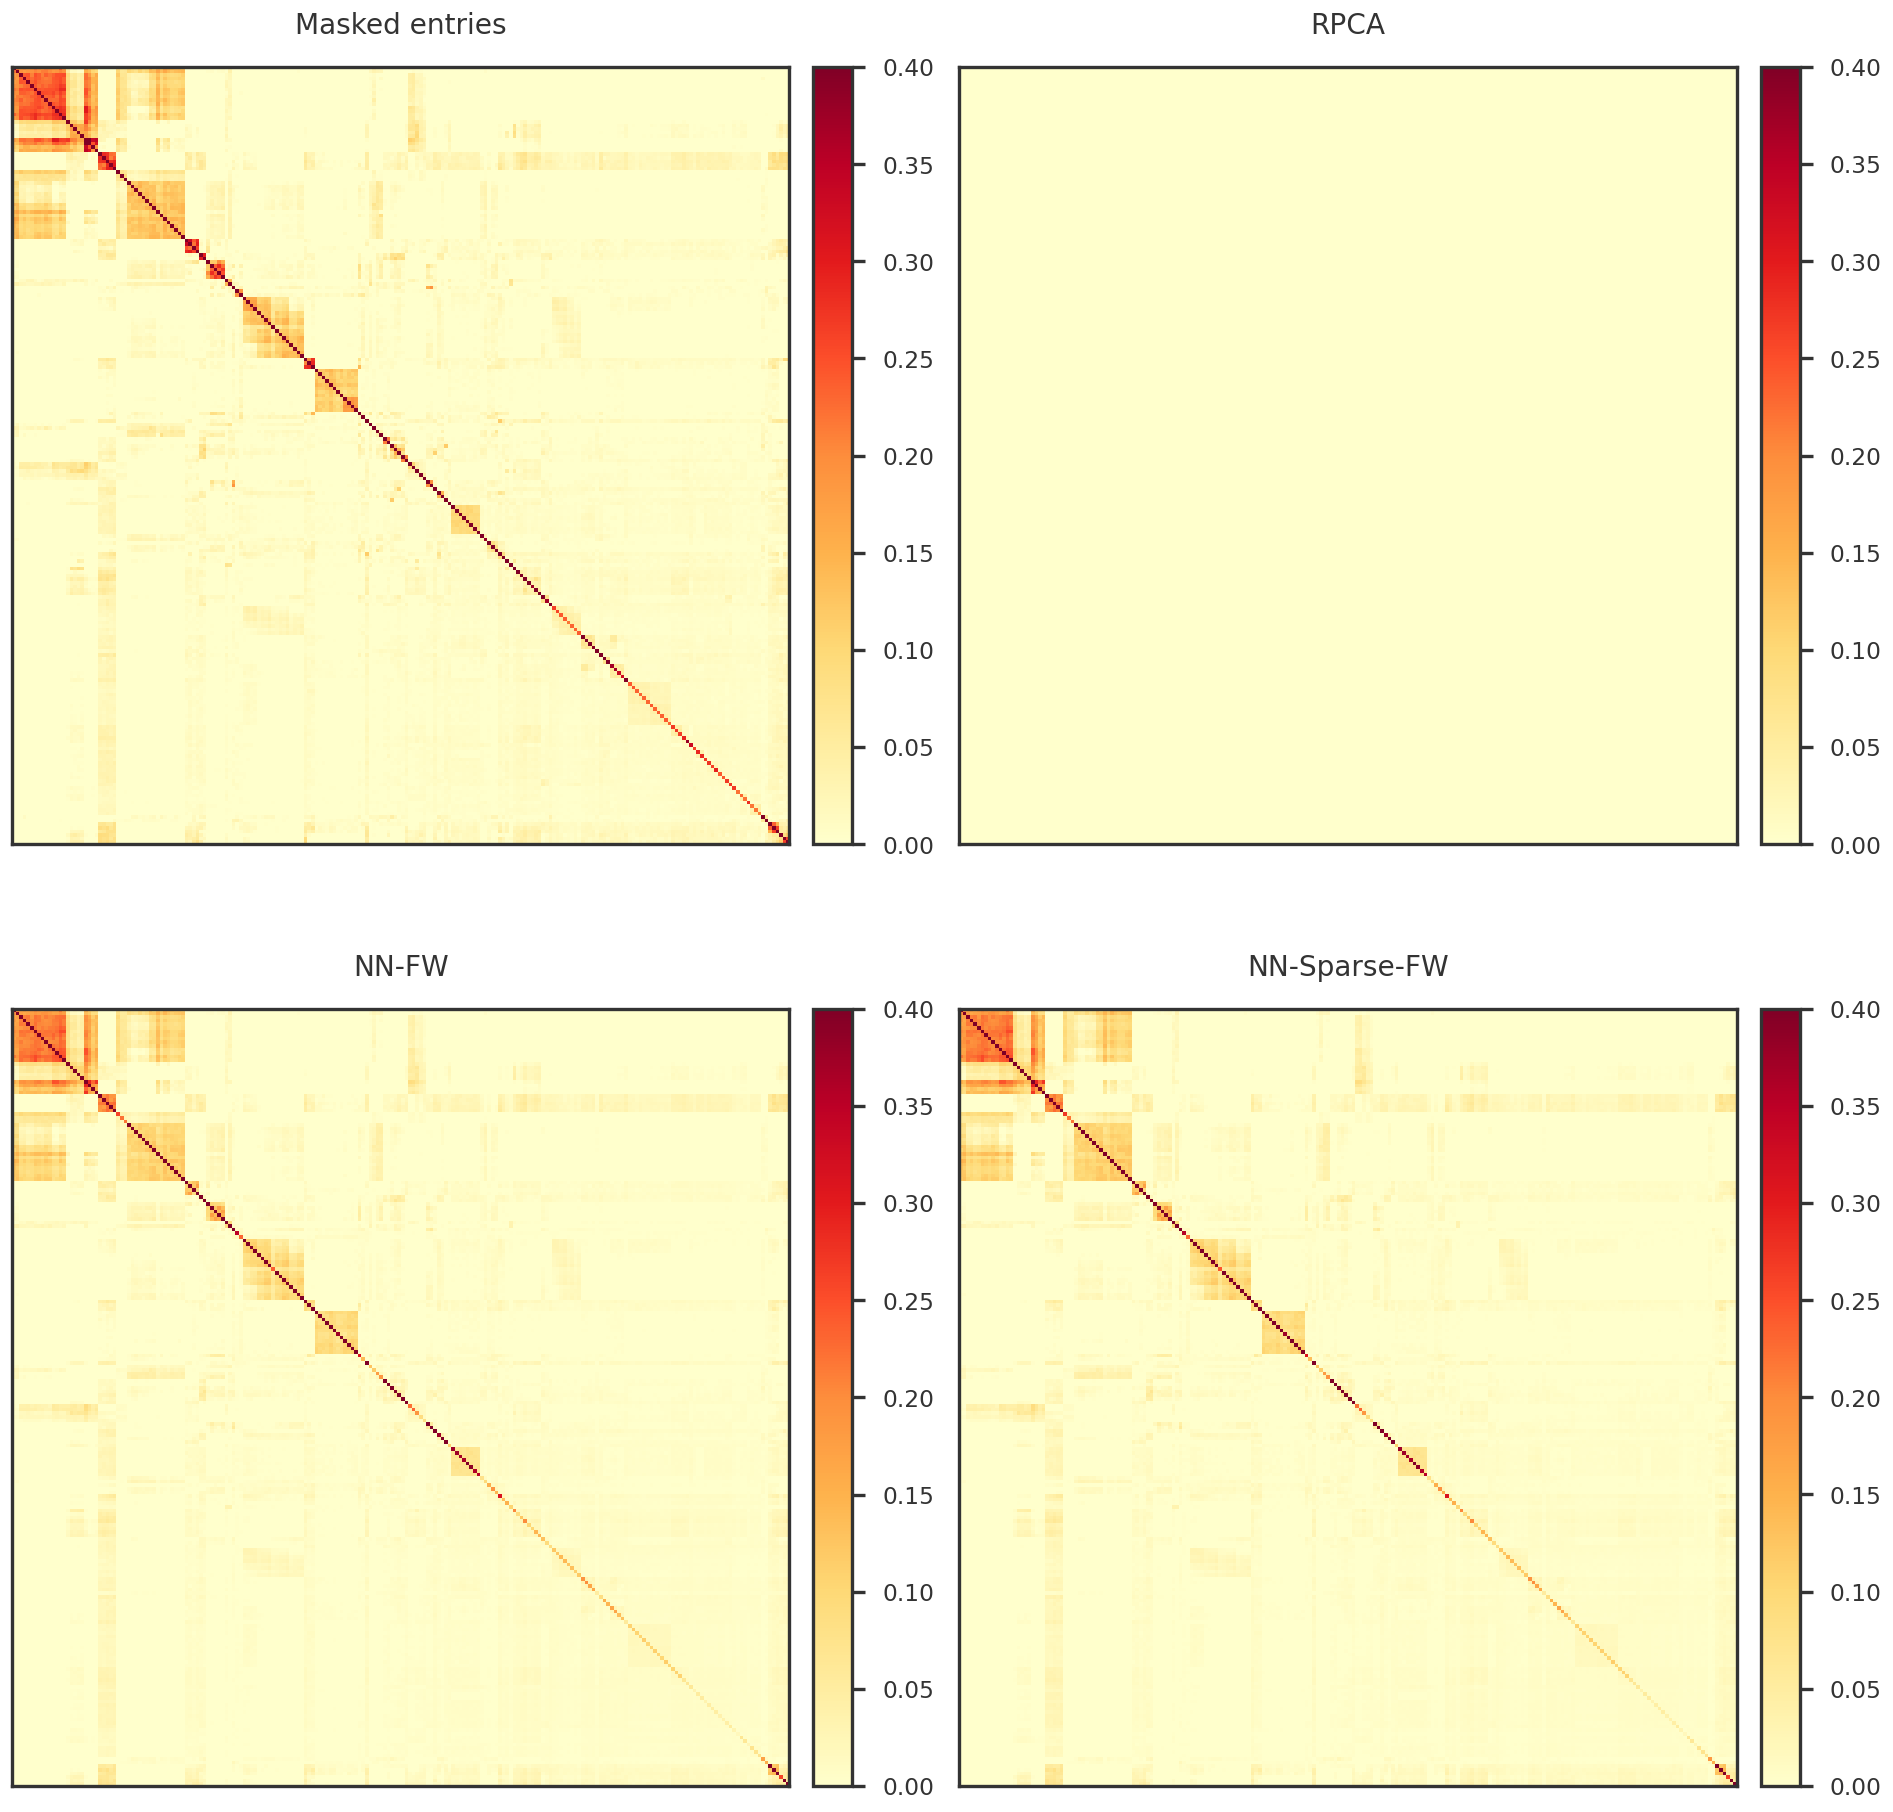

In [61]:
#| label: fig-recovered-masked-entries-correlation
#| fig-cap: "Correlation of Z-scores for the masked entries recovered by the different methods."


fig = plt.figure(figsize = (16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

X_cent_masked = X_cent.copy()
X_cent_masked[~Z_mask] = 0.0

rpca_X_masked = np.zeros_like(X_cent)
rpca_X_masked[Z_mask] = rpca_res['X'][Z_mask]

nnm_X_masked = np.zeros_like(X_cent)
nnm_X_masked[Z_mask] = nnm_res['X'][Z_mask]

nnm_sparse_X_masked = np.zeros_like(X_cent)
nnm_sparse_X_masked[Z_mask] = nnm_sparse_res['X'][Z_mask]


vmax = 0.4
mpy_plotfn.plot_covariance_heatmap(ax1, X_cent_masked[o1, :], vmax = vmax)
mpy_plotfn.plot_covariance_heatmap(ax2, rpca_X_masked[o1, :], vmax = vmax)
mpy_plotfn.plot_covariance_heatmap(ax3, nnm_X_masked[o1, :], vmax = vmax)
mpy_plotfn.plot_covariance_heatmap(ax4, nnm_sparse_X_masked[o1, :], vmax = vmax)

ax1.set_title("Masked entries", pad = 20)
ax2.set_title("RPCA", pad = 20)
ax3.set_title("NN-FW", pad = 20)
ax4.set_title("NN-Sparse-FW", pad = 20)

for ax in [ax1, ax2, ax3, ax4]:
    ax.tick_params(left = False, top = False, labelleft=False, labeltop=False)

plt.tight_layout()
plt.show()

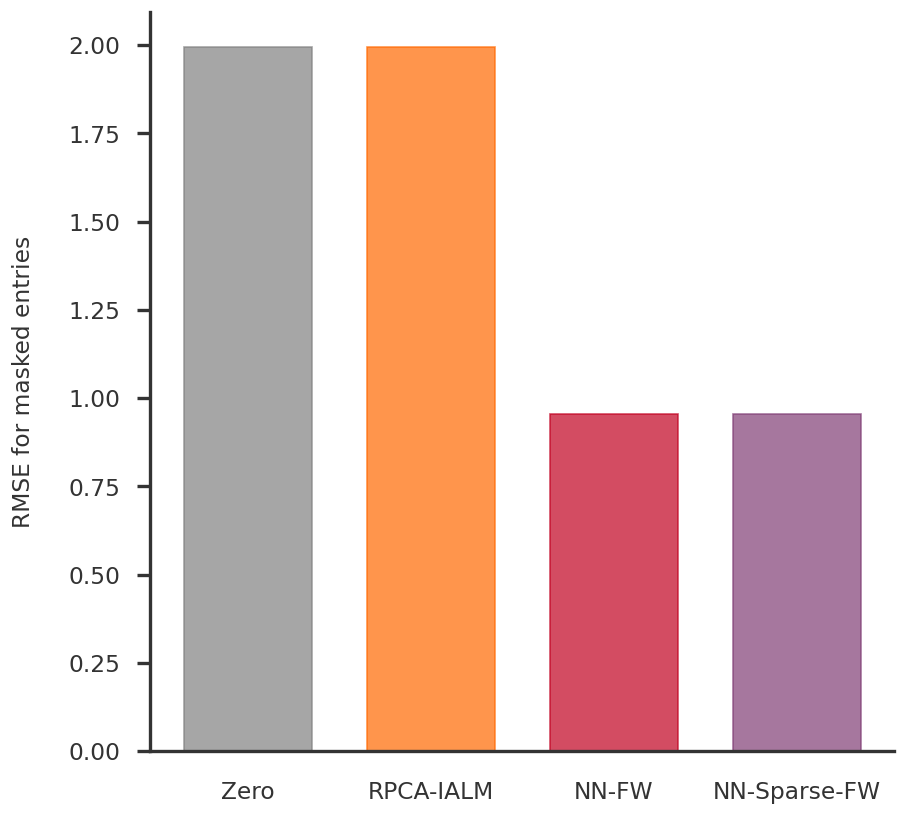

In [62]:
#| label: fig-rmse-optimum
#| fig-cap: "RMSE for recovery of masked entries"

fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)

yvals = [get_masked_rmse(X_cent, Z_cent, mask=Z_mask)] + list(optimum_rmse.values())
xvals = np.arange(len(yvals))
bcolors = ["grey"] + [method_colors[x] for x in optimum_rmse.keys()]

ax1.bar(xvals, yvals, align = 'center', width = 0.7, color = bcolors, edgecolor = bcolors, alpha = 0.7)
ax1.set_xticks(xvals)
ax1.set_xticklabels(["Zero"] + [method_labels[x] for x in optimum_rmse.keys()])

for side in ['top', 'right']:
    ax1.spines[side].set_visible(False)
    
ax1.tick_params(bottom=False)
ax1.set_ylabel("RMSE for masked entries")

plt.show()